<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/Final_v1/hybrid_model%20/ensemble/stack_model_selecting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib

In [ ]:
import tensorflow_hub as hub

In [ ]:
import os

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 7326 files belonging to 4 classes.
Using 5129 files for training.
Using 2197 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

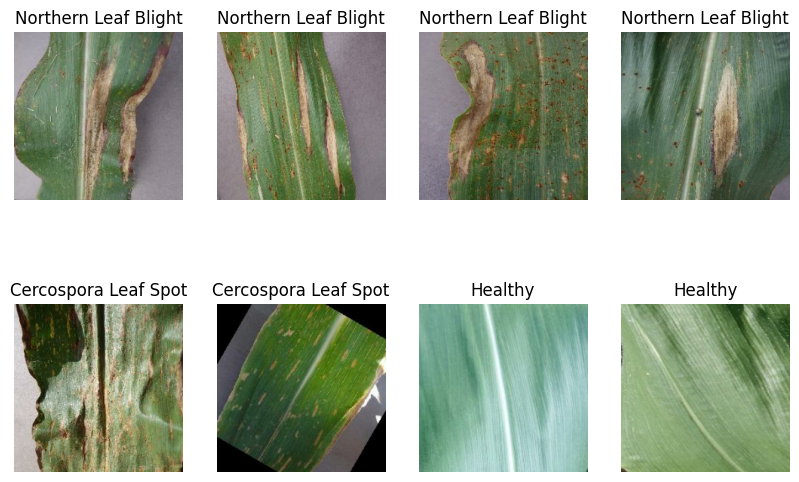

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 69


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 34


# CNN model

In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/CNN_model_selecting/custom_CNN/models/custom_cnn_model_depth_4_all_diseases.keras')
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

# vit

In [ ]:
vit_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/ViT_model_selecting/vit_b16/models/vit_b16_model.keras',safe_mode=False)
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 4)                 3076      
                                                                 
Total params: 85801732 (327.31 MB)
Trainable params: 85801732

# 1. Averaging

In [ ]:
def ensemble_predict_averaging(cnn_model, vit_model, test_dataset):
    # Get predictions from both models
    cnn_predictions = cnn_model.predict(test_dataset)
    vit_predictions = vit_model.predict(test_dataset)

    # Average the predictions
    averaged_predictions = (cnn_predictions + vit_predictions) / 2

    return np.argmax(averaged_predictions, axis=1)

In [ ]:
averaged_predictions = ensemble_predict_averaging(cnn_model, vit_model, test_dataset)

34/34 [==============================] - 17s 402ms/step


In [ ]:
averaged_predictions

array([0, 1, 3, ..., 2, 3, 1])

## Confusion matrix

In [ ]:
y_pred_classes = averaged_predictions

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([0, 1, 3, ..., 2, 3, 1], dtype=int32)

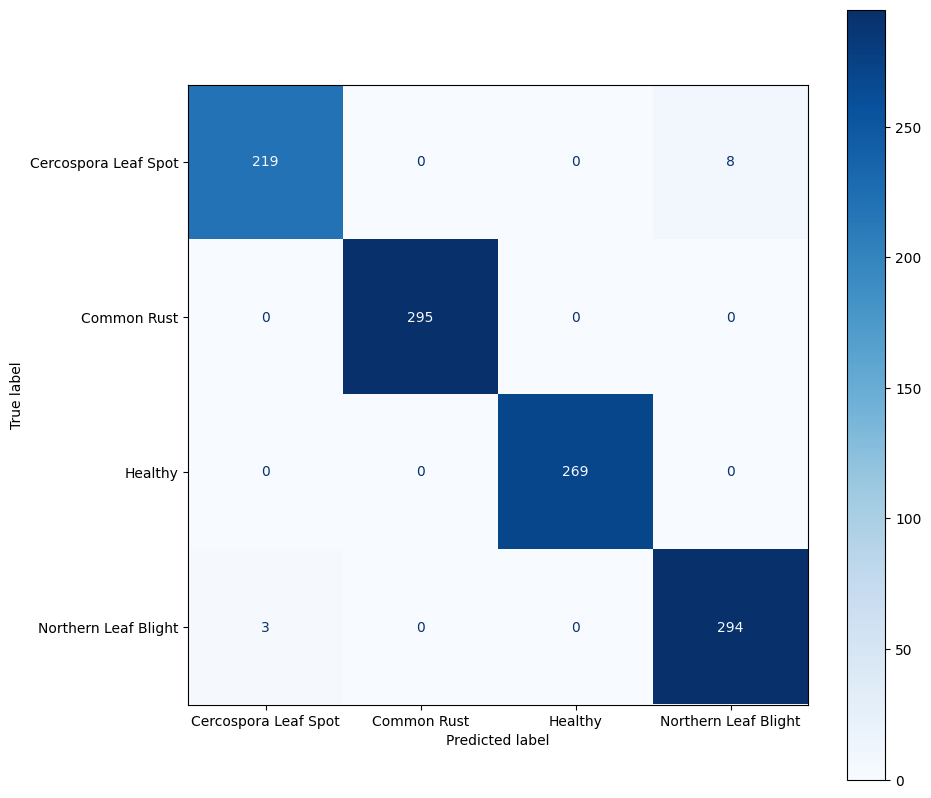

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))

                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.99      0.96      0.98       227
         Common Rust       1.00      1.00      1.00       295
             Healthy       1.00      1.00      1.00       269
Northern Leaf Blight       0.97      0.99      0.98       297

            accuracy                           0.99      1088
           macro avg       0.99      0.99      0.99      1088
        weighted avg       0.99      0.99      0.99      1088



## show incorrectly classified images

In [ ]:
# Find incorrectly classified images
incorrect_indices = np.where(y_pred_classes != y_true)[0]
incorrect_indices

array([ 60, 133, 172, 394, 417, 428, 463, 657, 660, 731, 742])

In [ ]:
# Get the images and labels
images = np.concatenate([x for x, y in test_dataset], axis=0)
incorrect_images = images[incorrect_indices]
incorrect_true_labels = y_true[incorrect_indices]
incorrect_pred_labels = y_pred_classes[incorrect_indices]

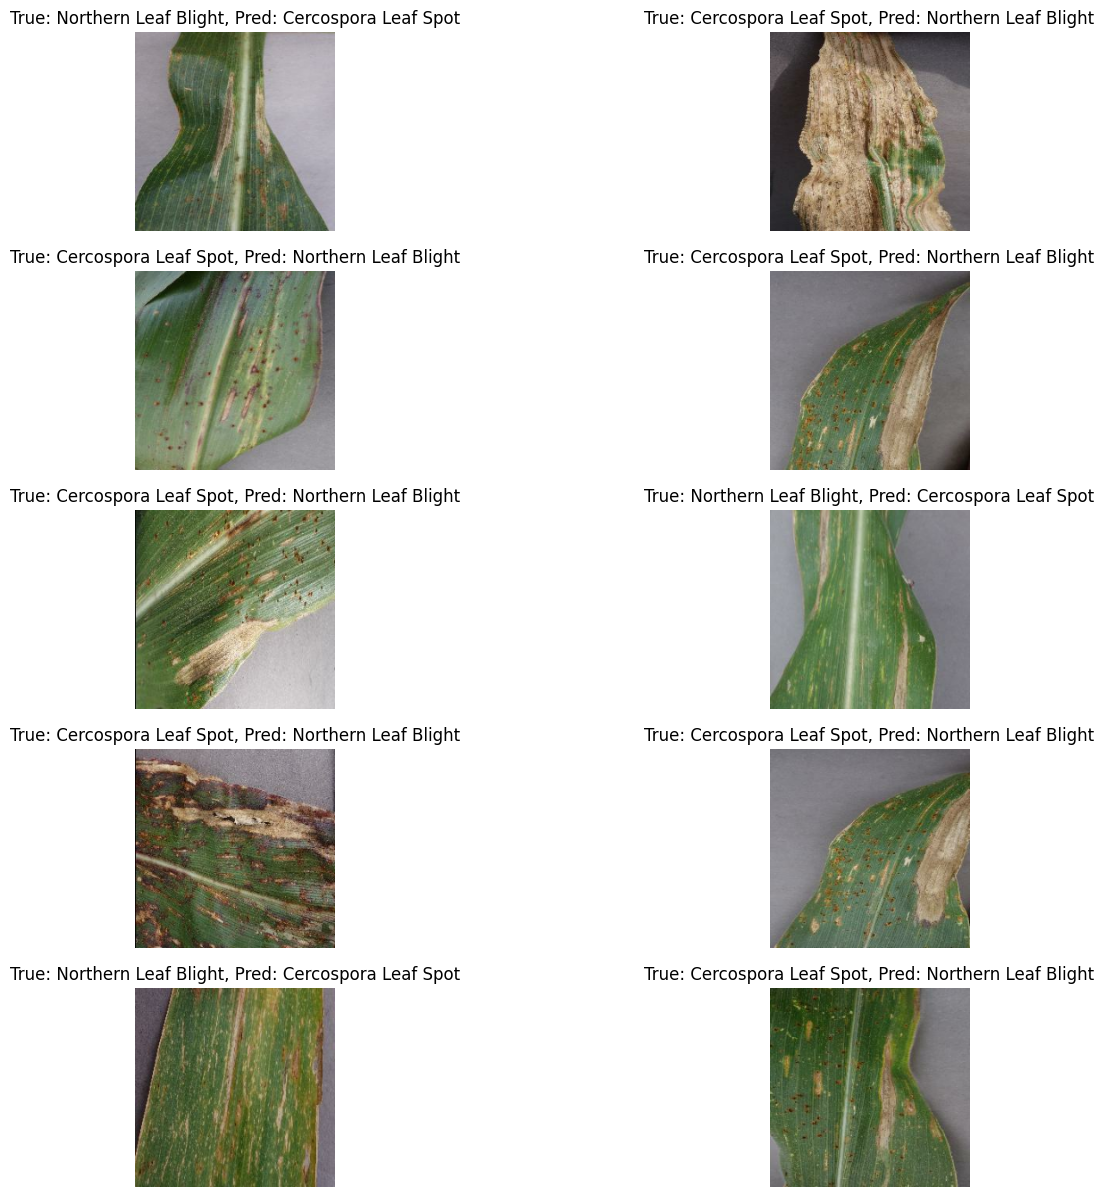

In [ ]:
# Display incorrectly classified images
num_images_to_display = 10  # Number of images to display
plt.figure(figsize=(15, 15))
for i in range(min(num_images_to_display, len(incorrect_images))):
    plt.subplot(5, 2, i + 1)
    plt.imshow(incorrect_images[i].astype("uint8"))
    plt.title(f"True: {class_names[incorrect_true_labels[i]]}, Pred: {class_names[incorrect_pred_labels[i]]}")
    plt.axis("off")
plt.show()

leaf spot : Mature lesions from gray leaf spot are rectangular, as they are restricted by the leaf veins.

leaf blight : Northern corn leaf blight is easily identified by the 1- to 6-inch cigar-shaped lesions on lower leaves, which may be grayish-green to tan in color.

# 2. Voting

In [ ]:
from scipy.stats import mode

def ensemble_predict_voting(cnn_model, vit_model, test_dataset):
    # Get predictions from both models
    cnn_predictions = np.argmax(cnn_model.predict(test_dataset), axis=1)
    vit_predictions = np.argmax(vit_model.predict(test_dataset), axis=1)

    # Combine predictions using majority voting
    combined_predictions = np.vstack((cnn_predictions, vit_predictions))
    final_predictions, _ = mode(combined_predictions, axis=0)

    return final_predictions.flatten()

In [ ]:
voting_predictions = ensemble_predict_voting(cnn_model, vit_model, test_dataset)
voting_predictions

34/34 [==============================] - 14s 400ms/step


array([0, 1, 3, ..., 2, 3, 1])

## Confusion matrix

In [ ]:
y_pred_classes = voting_predictions

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([0, 1, 3, ..., 2, 3, 1], dtype=int32)

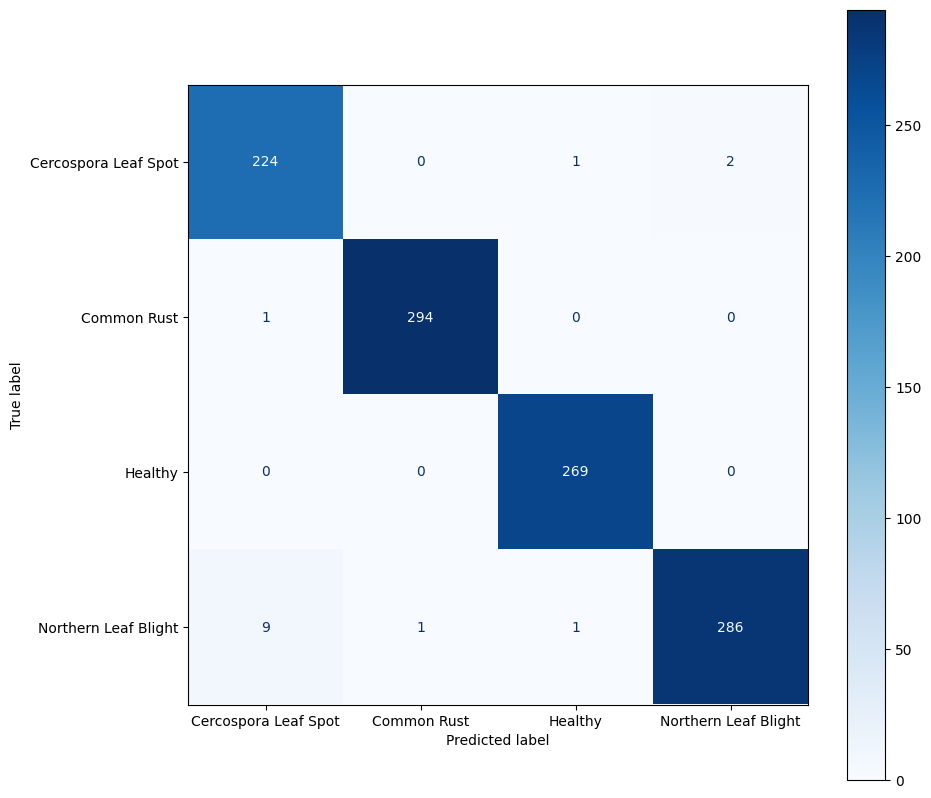

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))

                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.96      0.99      0.97       227
         Common Rust       1.00      1.00      1.00       295
             Healthy       0.99      1.00      1.00       269
Northern Leaf Blight       0.99      0.96      0.98       297

            accuracy                           0.99      1088
           macro avg       0.98      0.99      0.99      1088
        weighted avg       0.99      0.99      0.99      1088



# 3. Stacking

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


def stacking_ensemble(cnn_model, vit_model, validation_ds,test_ds, class_names):

    # Get predictions from both models
    cnn_predictions = cnn_model.predict(validation_ds)
    vit_predictions = vit_model.predict(validation_ds)

    # Extract true labels from the test dataset
    y_true_val = np.concatenate([y for x, y in validation_ds], axis=0)

    # Combine predictions as features
    combined_features_val = np.hstack((cnn_predictions, vit_predictions))

    # Train a simple classifier on the combined features
    stacking_model = RandomForestClassifier(n_estimators=100, random_state=42)
    stacking_model.fit(combined_features_val, y_true_val)

    # evaluation
    # Get predictions from both models for test data
    cnn_predictions_test = cnn_model.predict(test_ds)
    vit_predictions_test = vit_model.predict(test_ds)

    # Combine predictions as features
    combined_features_test = np.hstack((cnn_predictions_test, vit_predictions_test))

    # Extract true labels from the test dataset
    y_true_test = np.concatenate([y for x, y in test_ds], axis=0)

    # Evaluate the stacking model
    test_predictions = stacking_model.predict(combined_features_test)
    cm = confusion_matrix(y_true_test, test_predictions)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print(classification_report(y_true_test, test_predictions, target_names=class_names))

    return stacking_model

34/34 [==============================] - 786s 23s/step


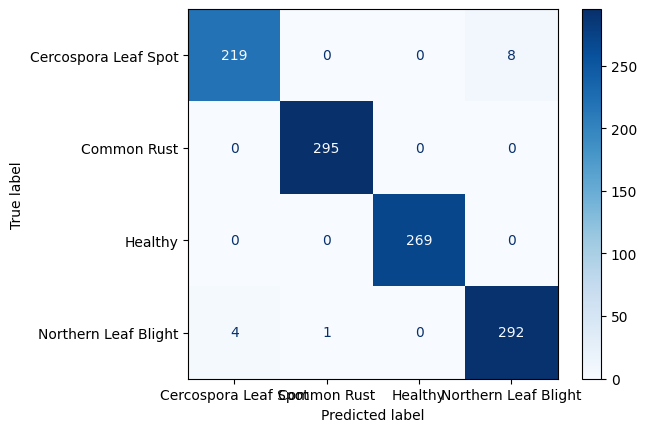

                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.98      0.96      0.97       227
         Common Rust       1.00      1.00      1.00       295
             Healthy       1.00      1.00      1.00       269
Northern Leaf Blight       0.97      0.98      0.98       297

            accuracy                           0.99      1088
           macro avg       0.99      0.99      0.99      1088
        weighted avg       0.99      0.99      0.99      1088



In [ ]:
class_names = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']
stacking_model = stacking_ensemble(cnn_model, vit_model,validation_dataset, test_dataset, class_names)

# GridSearch

In [ ]:
# Get predictions from both models
cnn_predictions = cnn_model.predict(validation_dataset)
vit_predictions = vit_model.predict(validation_dataset)

35/35 [==============================] - 23s 431ms/step


In [ ]:
# Stack predictions horizontally
stacked_predictions = np.hstack((cnn_predictions, vit_predictions))
stacked_predictions

array([[1.65984347e-05, 1.02569946e-04, 9.99826968e-01, ...,
        1.42841064e-03, 9.77796257e-01, 1.46938385e-02],
       [9.60514043e-03, 1.00675250e-04, 1.43206416e-05, ...,
        1.42642775e-05, 3.00058582e-05, 9.98110533e-01],
       [9.99994397e-01, 5.62918876e-06, 1.61930441e-30, ...,
        2.23531133e-05, 2.21979826e-06, 5.86006645e-05],
       ...,
       [9.99997854e-01, 2.12795590e-06, 4.79706810e-14, ...,
        2.38625180e-05, 9.25554195e-06, 1.40301185e-04],
       [1.57697260e-12, 1.00000000e+00, 7.06670939e-22, ...,
        9.99560416e-01, 3.88400622e-05, 1.25920560e-04],
       [5.42966118e-05, 4.60047295e-06, 9.99936104e-01, ...,
        2.12271418e-03, 8.94308269e-01, 5.99454939e-02]], dtype=float32)

In [ ]:
# Extract true labels from the validation dataset
y_true_val = np.concatenate([y for x, y in validation_dataset], axis=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
meta_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

In [ ]:
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}


In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [ ]:
# Define the scorers
scorers = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [ ]:
selected_scorer = 'f1'

best_model = None
best_score = 0
best_params = None

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Dictionary to hold the scores for each model
model_scores = {}

# Iterate over meta-models and perform grid search
for model_name, model in meta_models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], scoring=scorers[selected_scorer], cv=3)
    grid_search.fit(stacked_predictions, y_true_val)

    # Predict on validation set
    y_pred_val = grid_search.predict(stacked_predictions)

    # Calculate evaluation metrics
    precision = precision_score(y_true_val, y_pred_val, average='weighted')
    recall = recall_score(y_true_val, y_pred_val, average='weighted')
    f1 = f1_score(y_true_val, y_pred_val, average='weighted')
    accuracy = accuracy_score(y_true_val, y_pred_val)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true_val, y_pred_val)

    # Store the scores in the dictionary
    model_scores[model_name] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'best_params': grid_search.best_params_
    }

    # Check if this model is the best
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

# Print the scores for all models
for model_name, scores in model_scores.items():
    print(f"\nModel: {model_name}")
    print(f"Precision: {scores['precision']:.4f}")
    print(f"Recall: {scores['recall']:.4f}")
    print(f"F1 Score: {scores['f1_score']:.4f}")
    print(f"Accuracy: {scores['accuracy']:.4f}")
    print(f"Confusion Matrix:\n{scores['confusion_matrix']}")
    print(f"Best Parameters: {scores['best_params']}")

print(f'\nBest Meta-Model: {best_model}')
print(f'Best Parameters: {best_params}')



Model: Logistic Regression
Precision: 0.9892
Recall: 0.9892
F1 Score: 0.9892
Accuracy: 0.9892
Confusion Matrix:
[[234   0   0   8]
 [  0 306   0   0]
 [  0   0 285   0]
 [  3   0   1 272]]
Best Parameters: {'C': 0.1}

Model: Random Forest
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000
Confusion Matrix:
[[242   0   0   0]
 [  0 306   0   0]
 [  0   0 285   0]
 [  0   0   0 276]]
Best Parameters: {'n_estimators': 200}

Model: SVM
Precision: 0.9892
Recall: 0.9892
F1 Score: 0.9892
Accuracy: 0.9892
Confusion Matrix:
[[234   0   0   8]
 [  0 306   0   0]
 [  0   0 285   0]
 [  3   0   1 272]]
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Model: Gradient Boosting
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000
Confusion Matrix:
[[242   0   0   0]
 [  0 306   0   0]
 [  0   0 285   0]
 [  0   0   0 276]]
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}

Model: KNN
Precision: 0.9892
Recall: 0.9892
F1 Score: